# Electricity Consumption Forecast (SE)

- `Objective`: Forecast daily electricity consumption in Sweden for 2022.
- `Potential Business Impact`: more accurate budgeting and potential cost savings. 
- `Dataset`: ~2K rows × 8 columns.
- `Assumption`: Accurate forecast for the following day is available.
- `Features`: Temperature data (Stockholm, Gothenburg, Lund), Holidays, GWh lags for 7 days.
- `Source`: Vattenfall - Swedish multinational power company. 

[Here](./Electricity%20Consumption%20Forecast%20(SE).pdf) you can find a short project presentaion. 

According to Vattenfall:
"The most important thing is not to train the most puncture-proof model (although that is a plus), but for
you manage to **report your work process** and **justify your assumptions**".

Data Description:

- `CNPSE`: daily series of total consumption from **2017 to 2022** (in **GWh**); 
- `TEMPSTO`: historical temperature data for Stockholm (°C);
- `TEMPGOTB`: historical temperature data for Gothenburg (°C);
- `TEMPLUND`: historical temperature data for Lund (°C)

------------
- `MAE` = error measure (asked by the company)
- Python package holidays for national holiday days check.


## Data Inspection

In [35]:
# Basic imports related to analysis
import pandas as pd
import numpy as np

# Imports for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ML related imports
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Imports related to holidays
import holidays

# Silence warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_excel('./kodtest_data.xlsx')
df

,Day,CNPSE,TEMPSTO,TEMPGOTB,TEMPLUND
0,2017-01-01,374.228,4.0,4.1,5.8
1,2017-01-02,478.835,-1.0,-1.7,1.1
2,2017-01-03,497.661,-3.1,1.8,3.5
3,2017-01-04,514.413,-4.3,-0.8,1.8
4,2017-01-05,575.948,-9.3,-7.9,-6.6
...,...,...,...,...,...
2186,2022-12-27,419.802,1.9,4.4,3.7
2187,2022-12-28,434.897,-0.7,3.1,5.0
2188,2022-12-29,398.389,4.3,7.0,7.5
2189,2022-12-30,384.390,4.7,5.9,6.1


In [5]:
df.rename(columns={
    'CNPSE': 'Daily Total Cons.(GWh)',
    'TEMPSTO': 'Temp. Stockholm',
    'TEMPGOTB': 'Temp. Gotenberg',
    'TEMPLUND': 'Temp. Lund',
    'Day': 'Date'

}, inplace=True)

In [6]:
def parse_start_date(df):
    df['Date'] =pd.to_datetime(df.Date) 
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day of year'] = df.Date.dt.dayofyear

parse_start_date(df)

In [7]:
df

,Date,Daily Total Cons.(GWh),Temp. Stockholm,Temp. Gotenberg,Temp. Lund,Year,Month,Day of year
0,2017-01-01,374.228,4.0,4.1,5.8,2017,1,1
1,2017-01-02,478.835,-1.0,-1.7,1.1,2017,1,2
2,2017-01-03,497.661,-3.1,1.8,3.5,2017,1,3
3,2017-01-04,514.413,-4.3,-0.8,1.8,2017,1,4
4,2017-01-05,575.948,-9.3,-7.9,-6.6,2017,1,5
...,...,...,...,...,...,...,...,...
2186,2022-12-27,419.802,1.9,4.4,3.7,2022,12,361
2187,2022-12-28,434.897,-0.7,3.1,5.0,2022,12,362
2188,2022-12-29,398.389,4.3,7.0,7.5,2022,12,363
2189,2022-12-30,384.390,4.7,5.9,6.1,2022,12,364


### Import Holidays

In [8]:
def is_holiday(date):
    se_holidays = holidays.Sweden()
    return date in se_holidays

df['Is Holiday'] = df['Date'].apply(lambda x: int(is_holiday(x)))

In [9]:
for year in df.Year.unique(): 
    print(df[(df['Is Holiday'] == 1) & (df['Year'] == year)].shape,)

(64, 9)
(66, 9)
(65, 9)
(66, 9)
(64, 9)
(64, 9)


In [10]:
holidays.Sweden()['2023-09-24']

'Söndag'

Result: they include Sundays in the library. We'll stick with this for now, because prople in Sweden tend to not work on Sundays. 

In [11]:
df.shape

(2191, 9)

In [12]:
df.groupby('Date').sum().shape

(2191, 8)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2191 non-null   datetime64[ns]
 1   Daily Total Cons.(GWh)  2191 non-null   float64       
 2   Temp. Stockholm         2191 non-null   float64       
 3   Temp. Gotenberg         2191 non-null   float64       
 4   Temp. Lund              2191 non-null   float64       
 5   Year                    2191 non-null   int32         
 6   Month                   2191 non-null   int32         
 7   Day of year             2191 non-null   int32         
 8   Is Holiday              2191 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int32(3), int64(1)
memory usage: 128.5 KB


In [14]:
df.describe()

,Date,Daily Total Cons.(GWh),Temp. Stockholm,Temp. Gotenberg,Temp. Lund,Year,Month,Day of year,Is Holiday
count,2191,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,2020-01-01 00:00:00,372.927392,8.548517,9.750114,10.014103,2019.500228,6.523962,183.083524,0.177545
min,2017-01-01 00:00:00,242.193000,-12.200000,-9.900000,-10.400000,2017.000000,1.000000,1.000000,0.000000
25%,2018-07-02 12:00:00,314.336500,2.400000,4.300000,4.600000,2018.000000,4.000000,92.000000,0.000000
50%,2020-01-01 00:00:00,361.819000,7.800000,9.600000,9.900000,2020.000000,7.000000,183.000000,0.000000
75%,2021-07-01 12:00:00,431.151000,14.900000,15.800000,15.800000,2021.000000,10.000000,274.000000,0.000000
max,2022-12-31 00:00:00,581.538000,26.900000,27.400000,26.400000,2022.000000,12.000000,366.000000,1.000000
std,NaN,72.226977,7.717621,7.063601,6.811142,1.707859,3.449207,105.438536,0.382216


In [15]:
def with_nans(dataset):
    # Find columns with NaN values and count such values
    with_nan = dataset.isna().sum()
    # Return appropriate message if no NaNs are found
    if with_nan[with_nan > 0].empty:
        print('No NaN values found.')
    else:
        return with_nan[with_nan > 0]

# Check training set for NaNs
with_nans(df)

No NaN values found.


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2191 non-null   datetime64[ns]
 1   Daily Total Cons.(GWh)  2191 non-null   float64       
 2   Temp. Stockholm         2191 non-null   float64       
 3   Temp. Gotenberg         2191 non-null   float64       
 4   Temp. Lund              2191 non-null   float64       
 5   Year                    2191 non-null   int32         
 6   Month                   2191 non-null   int32         
 7   Day of year             2191 non-null   int32         
 8   Is Holiday              2191 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int32(3), int64(1)
memory usage: 128.5 KB


In [17]:
df.head()

,Date,Daily Total Cons.(GWh),Temp. Stockholm,Temp. Gotenberg,Temp. Lund,Year,Month,Day of year,Is Holiday
0,2017-01-01,374.228,4.0,4.1,5.8,2017,1,1,1
1,2017-01-02,478.835,-1.0,-1.7,1.1,2017,1,2,0
2,2017-01-03,497.661,-3.1,1.8,3.5,2017,1,3,0
3,2017-01-04,514.413,-4.3,-0.8,1.8,2017,1,4,0
4,2017-01-05,575.948,-9.3,-7.9,-6.6,2017,1,5,0


In [18]:
# remove black frames
sns.despine(trim=True, right=True)

# Set style to 'darkgrid'
sns.set(style='darkgrid')


# Clear Matplotlib cache and save the plot in high resolution 
plt.rcParams.update({'figure.dpi': 300})
plt.savefig('output_figure.png')

<Figure size 640x480 with 0 Axes>

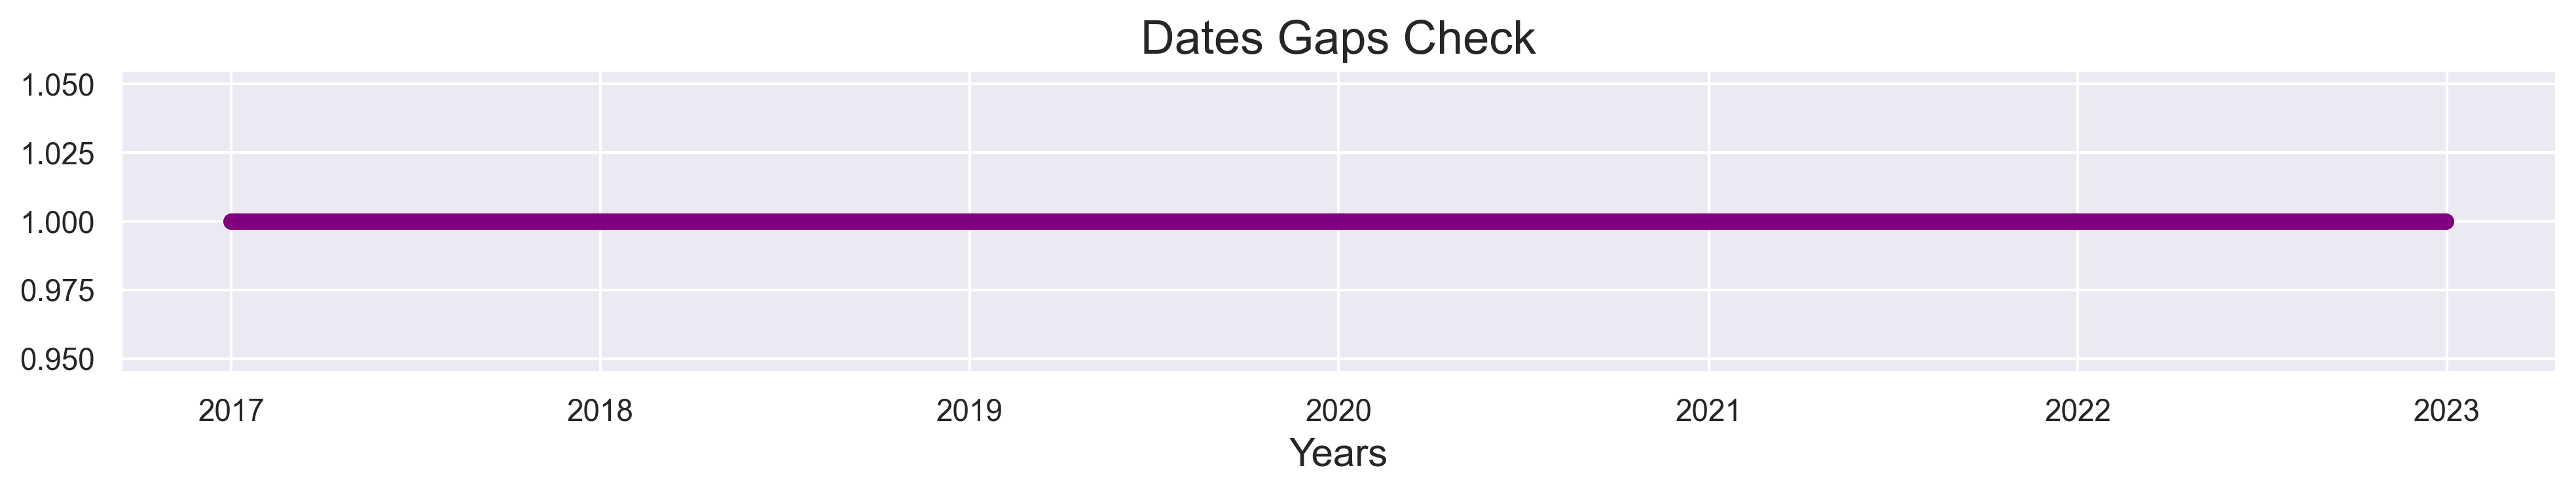

In [19]:
# Set up grid
plt.figure(figsize=(16, 2))
# Put data on the plots
sns.scatterplot(data=df, x='Date', y=1, linewidth=0, color='purple')


# Add title
plt.title('Dates Gaps Check', fontsize = 'x-large')
plt.xlabel('Years', fontsize = 'large')
# Show the result
plt.show()

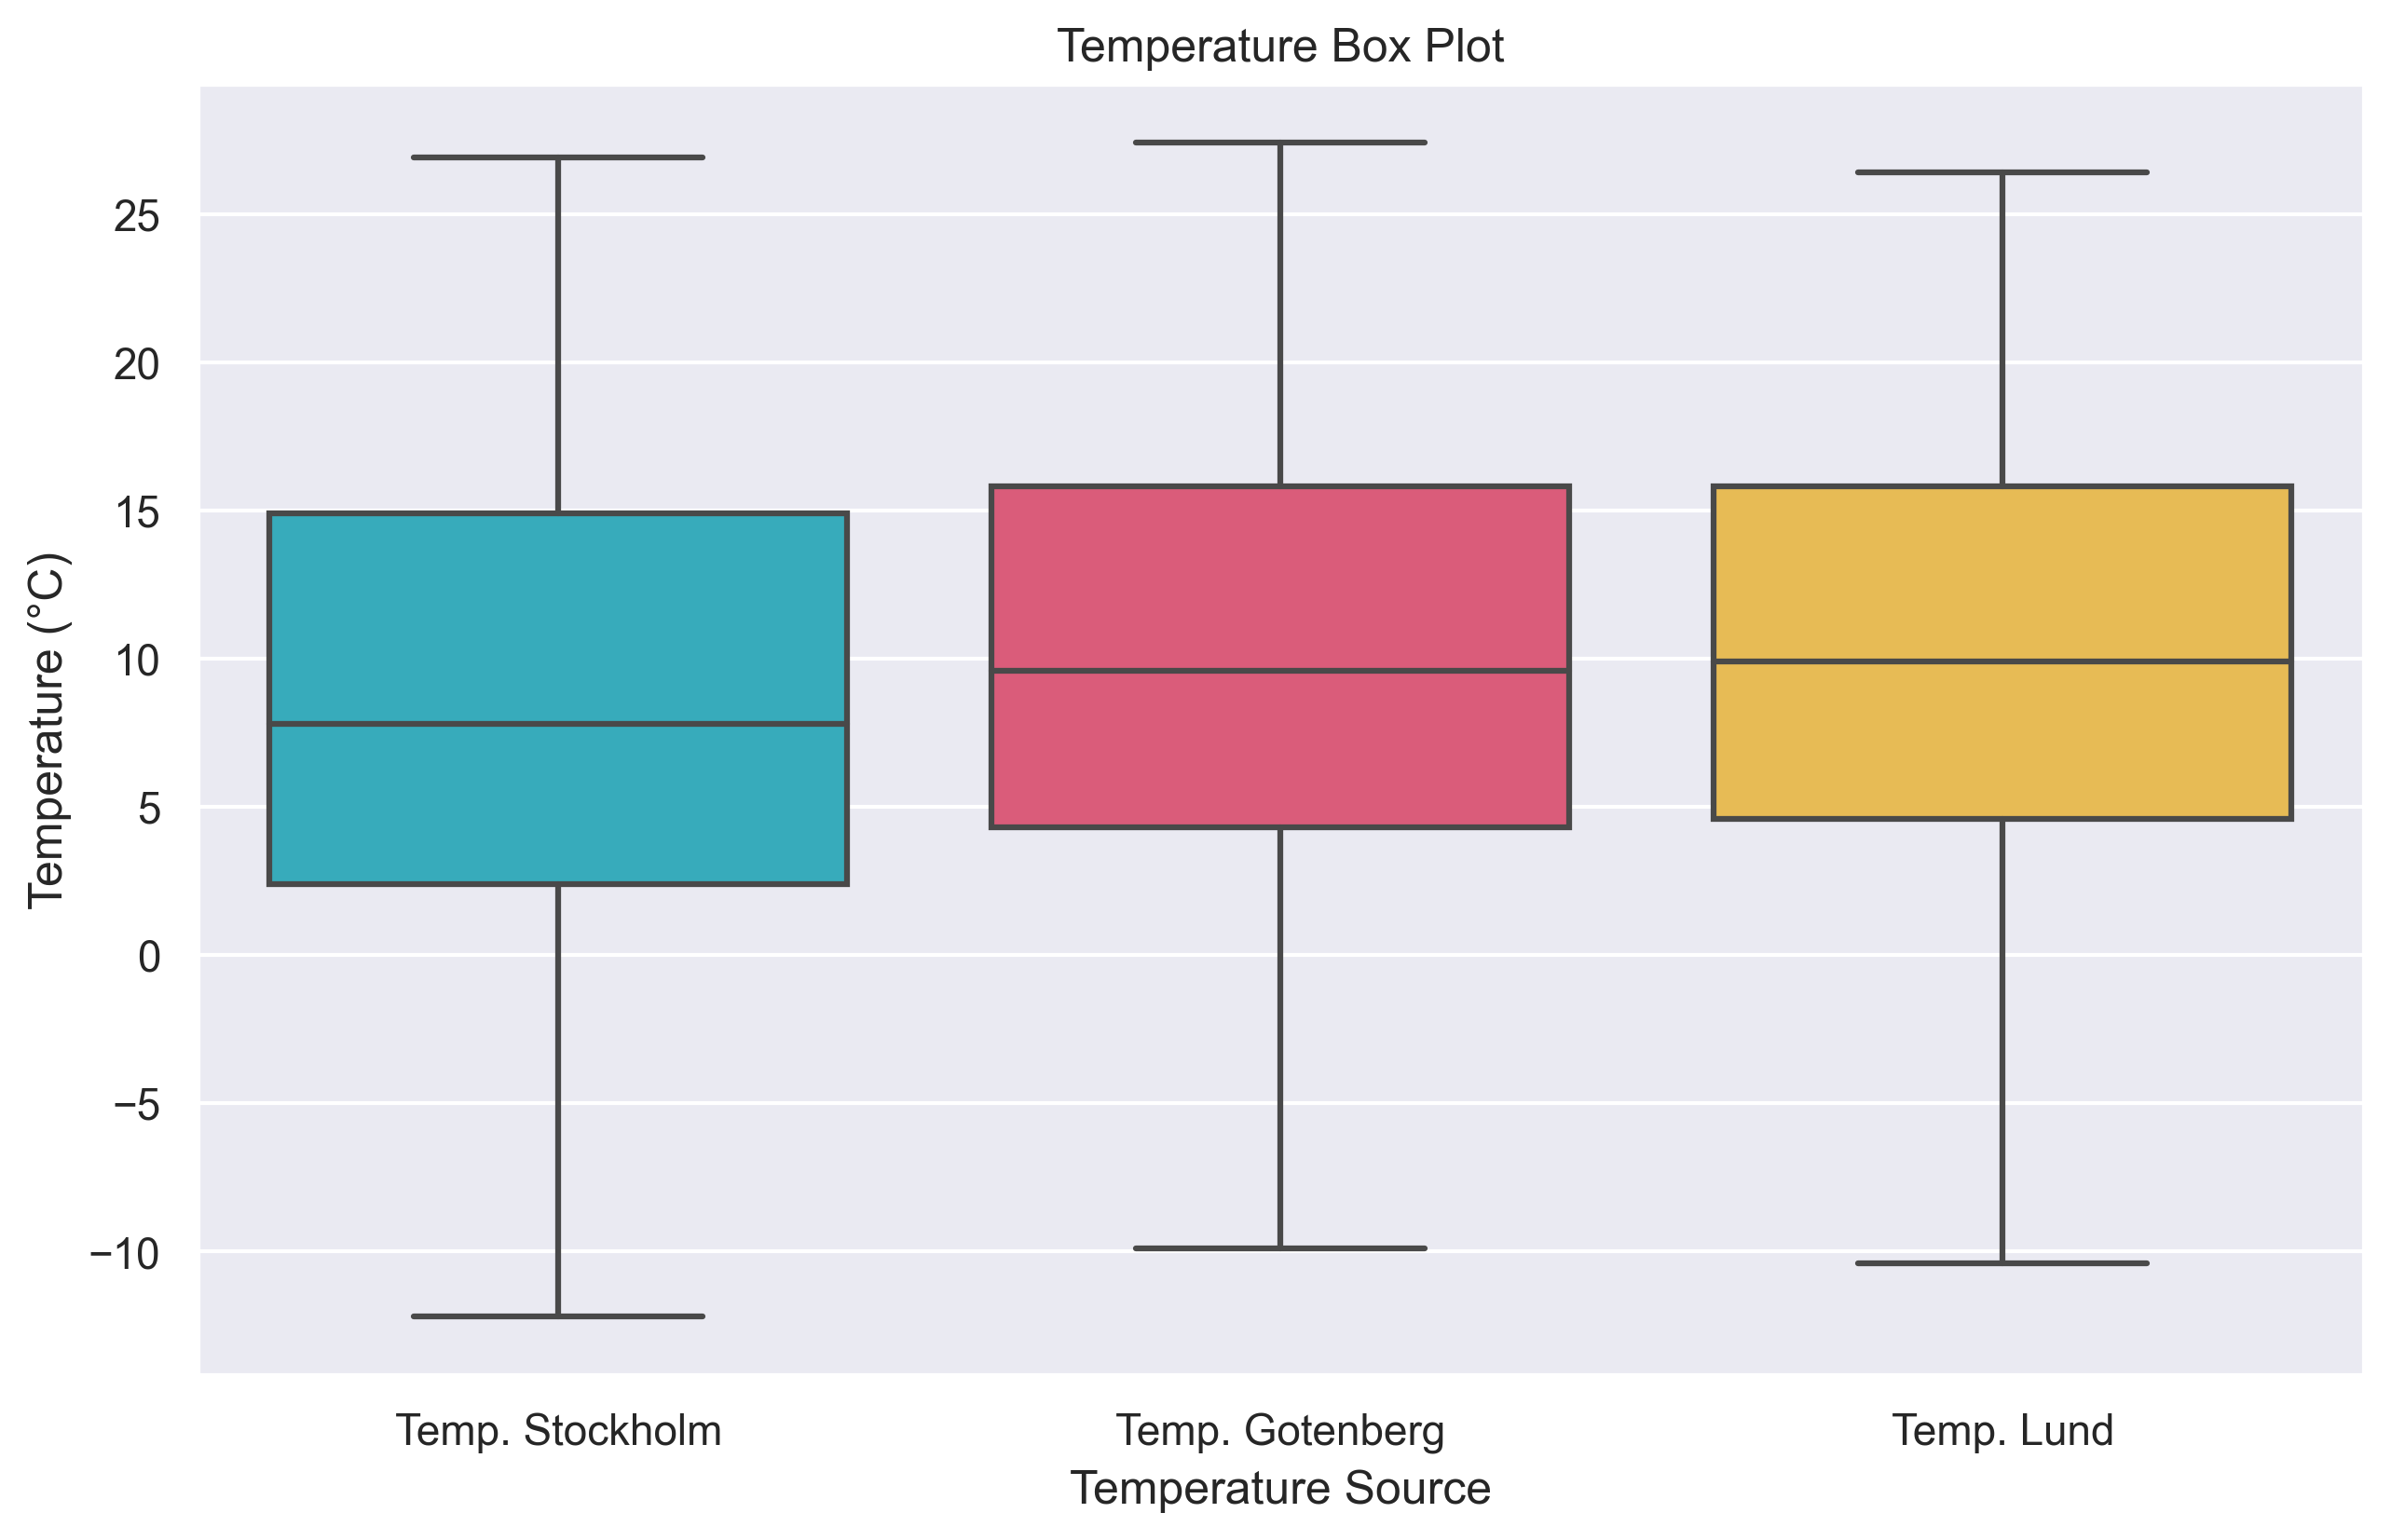

In [20]:
# Select the temperature columns
temperature_data = df[['Temp. Stockholm', 'Temp. Gotenberg', 'Temp. Lund']]

# Create a box plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(data=temperature_data, palette=['#21BCD1', '#EF476F', '#FFC43D'])
plt.title('Temperature Box Plot')
plt.xlabel('Temperature Source')
plt.ylabel('Temperature (°C)')
plt.show()

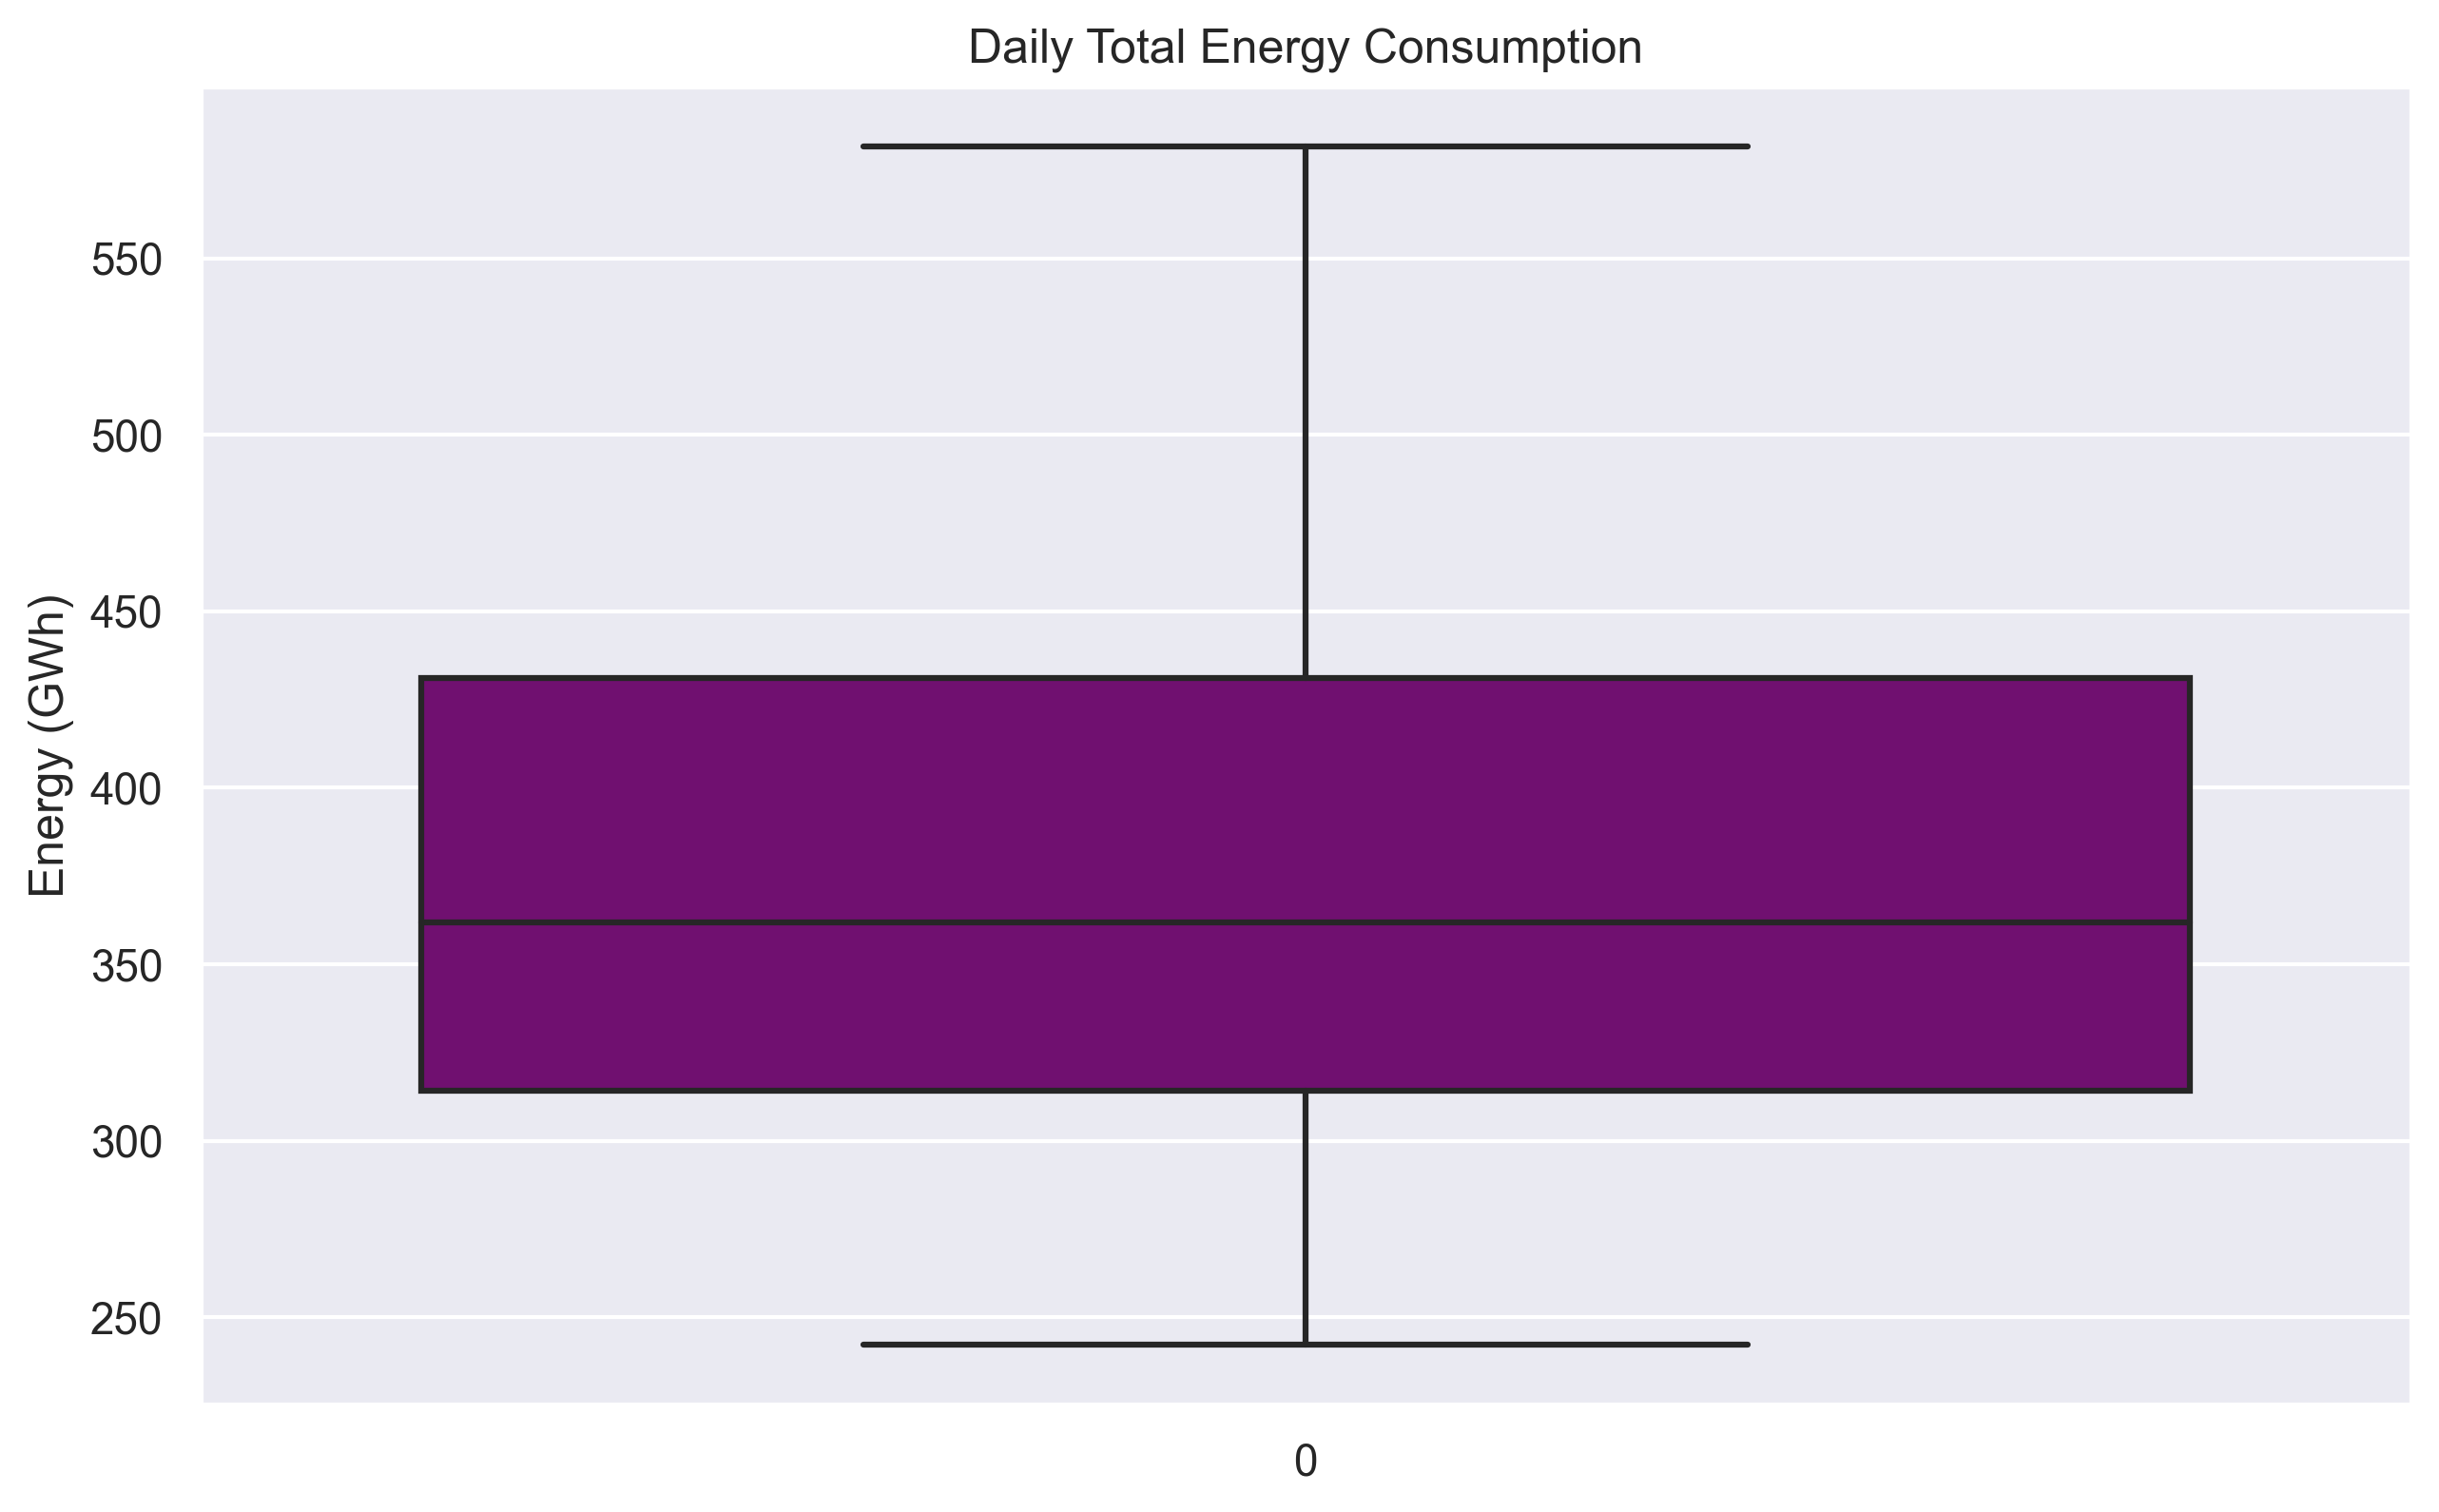

In [21]:
# Create a box plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(data=df['Daily Total Cons.(GWh)'], color='purple')
plt.title('Daily Total Energy Consumption')
plt.xlabel('')
plt.ylabel('Energy (GWh)')
plt.show()

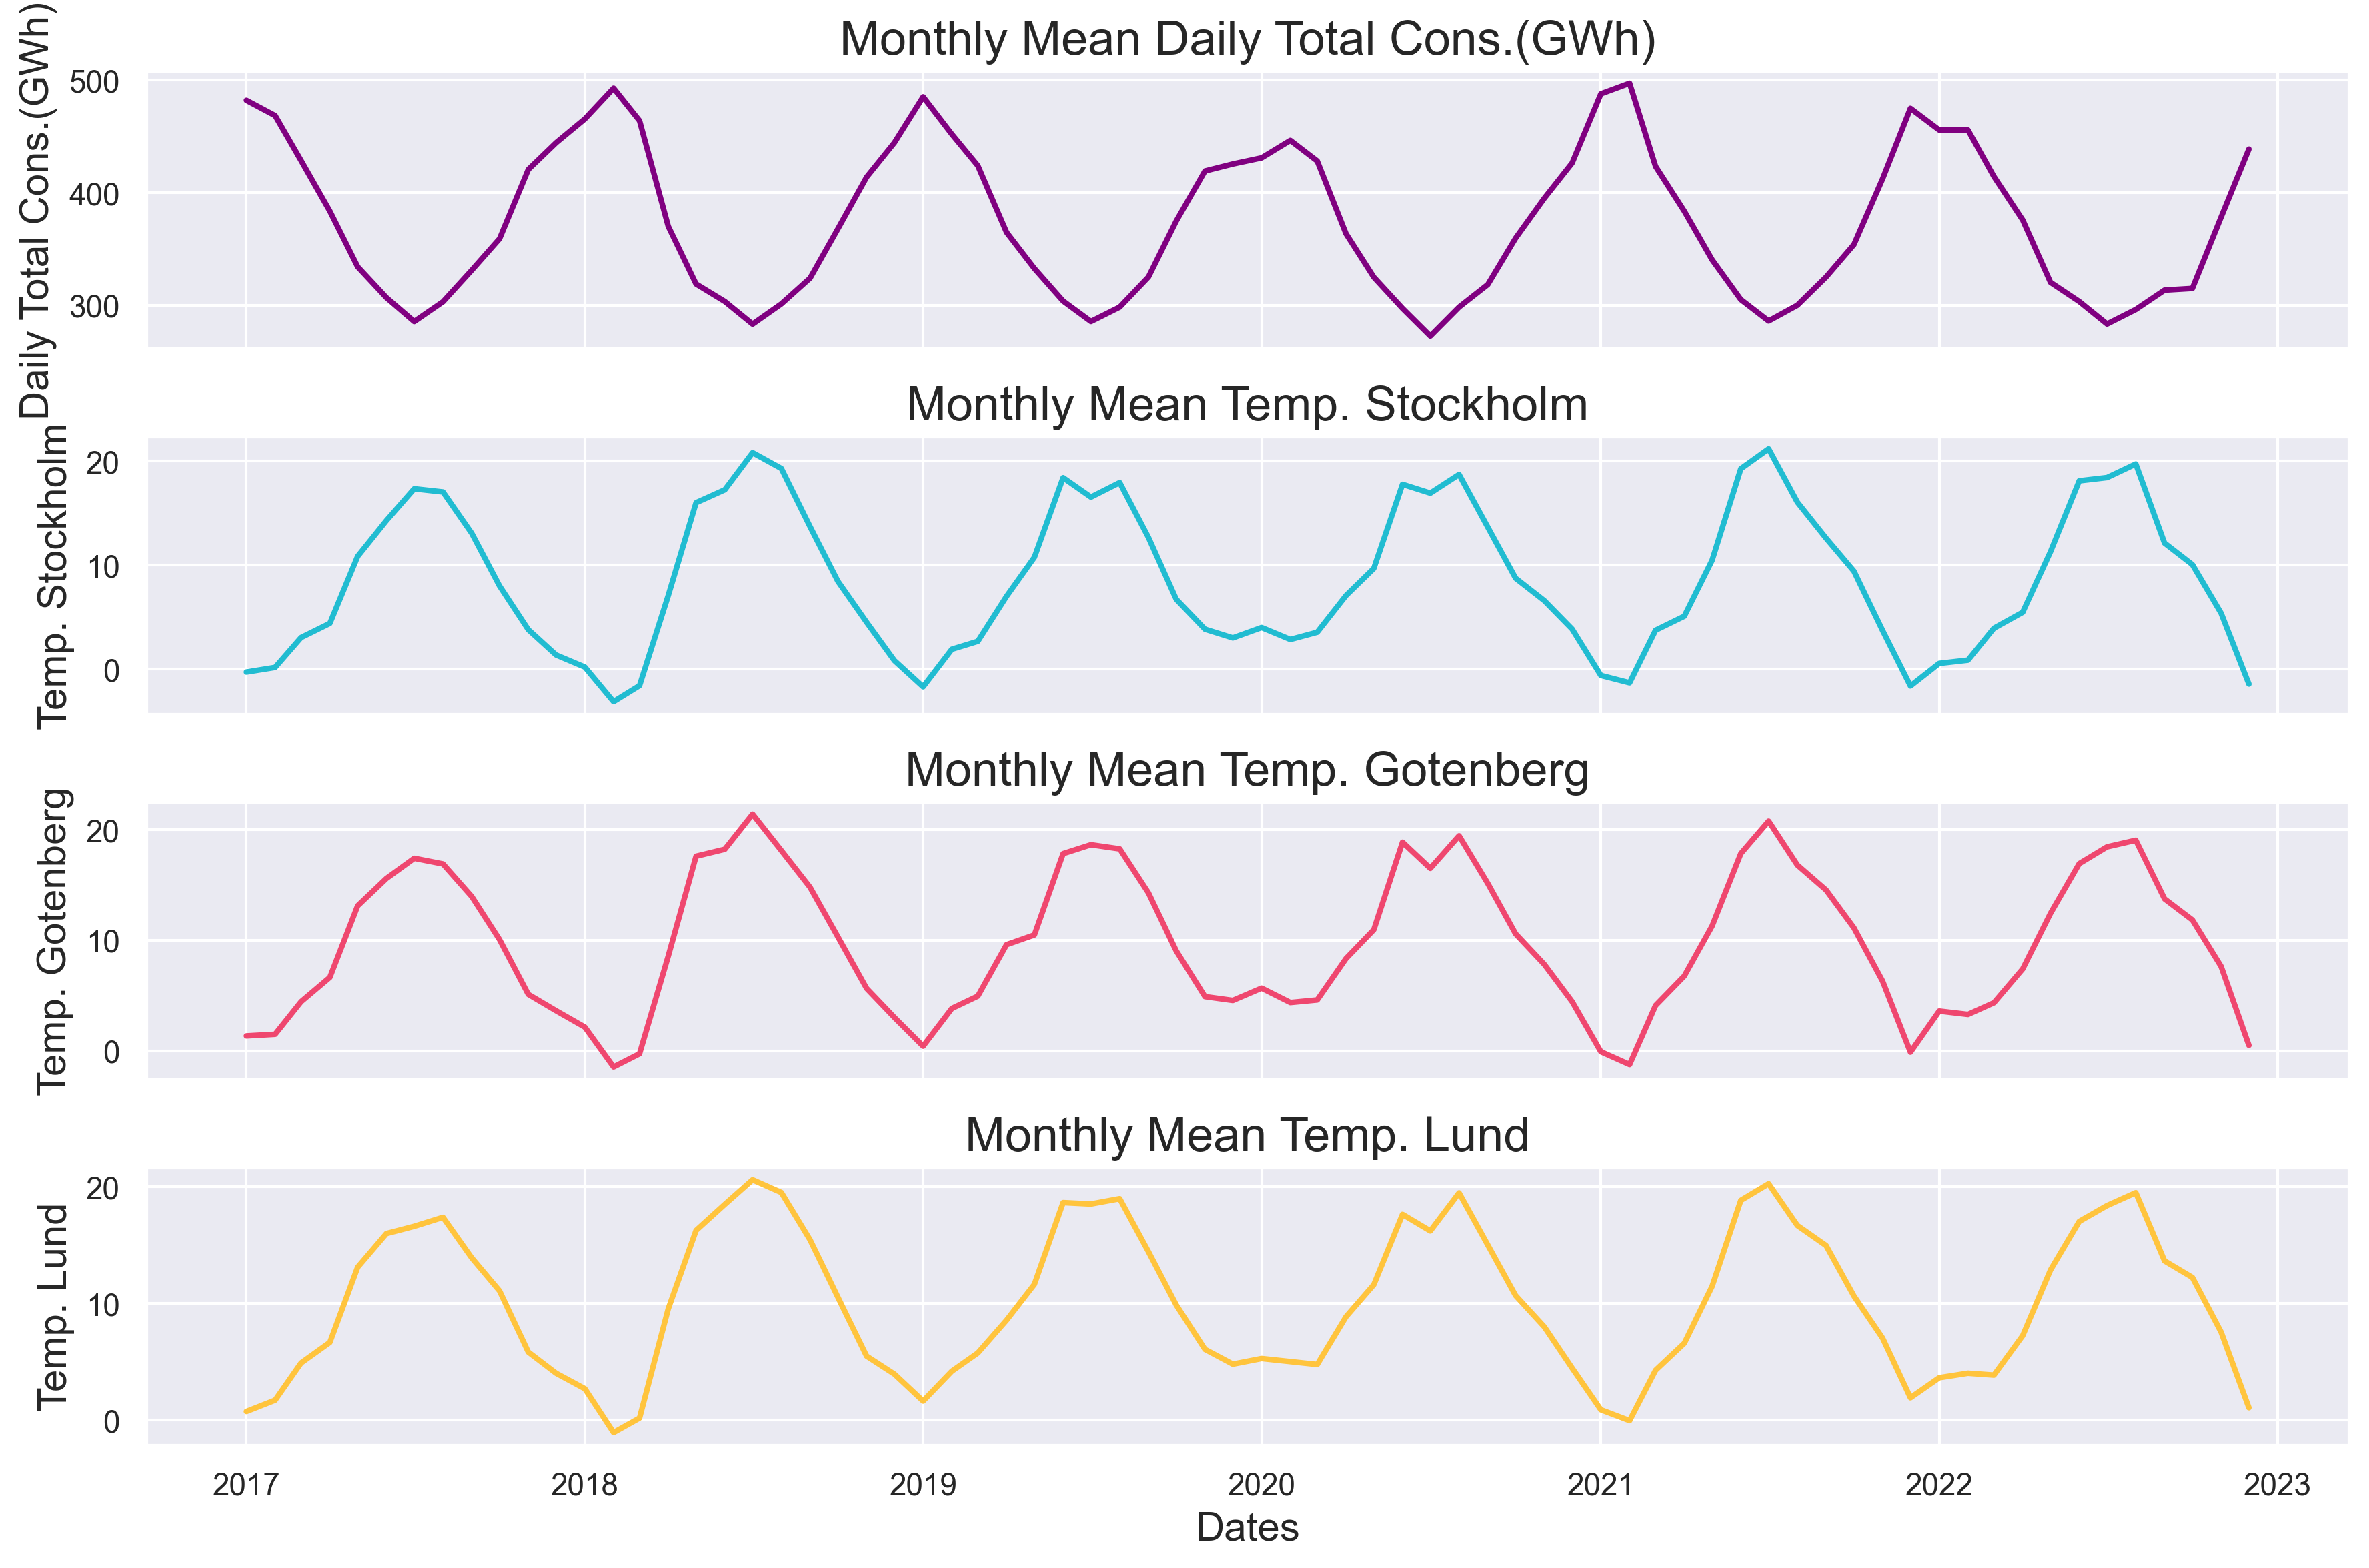

In [22]:
# Calculate monthly means for the specified columns
monthly_means = df.groupby(df['Date'].dt.to_period("M")).mean()

# Take dates
dates = monthly_means.index.to_timestamp()

# Define the columns to plot
columns_to_plot = ["Daily Total Cons.(GWh)", "Temp. Stockholm", "Temp. Gotenberg", "Temp. Lund"]

# Create subplots
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(12, 8), sharex=True)

# Define colors for the plots
colors = ['purple', '#21BCD1', '#EF476F', '#FFC43D',]

# Plot each column
for i, column in enumerate(columns_to_plot):
    ax = sns.lineplot(data=monthly_means, x=dates, y=column, ax=axes[i], color=colors[i], linewidth=2.0)
    ax.set_ylabel(column,  fontsize = 'large')
    ax.set_xlabel('')
    ax.set_title(f'Monthly Mean {column}',  fontsize = 'x-large')

ax.set_xlabel('Dates', fontsize = 'large')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Build Models

### Lag Features 

Using lag features, also known as **time lag or time-shifted features**, involves incorporating past values of a variable (in this case, daily electricity consumption) as features in a predictive model. These lagged values **represent historical data points** and can be used to capture the temporal dependencies and patterns in the data. When we assume that we have an accurate forecast for the following day, it means we can use historical data to predict future values.

#### Date-related features

Using lag features with `Year`, `Month`, and `Day` as predictors in a forecasting model can introduce challenges and potential issues.

1. **Sparsity and Dimensionality:** Including `Year`, `Month`, and `Day` as lagged features can lead to high dimensionality and sparsity. Each of these features would generate its own set of lagged values, significantly increasing the number of predictor variables. This can make the dataset sparse, especially if not all combinations of `Year`, `Month`, and `Day` are present in the data.

2. **Lack of Temporal Information:** `Year`, `Month`, and `Day` are calendar-related features and may not provide meaningful temporal information when used as lagged features. For example, the difference between `Year=2021` and `Year=2022` may not be relevant for predicting daily electricity consumption. These features are better suited for capturing seasonality and long-term trends rather than short-term dependencies.

3. **Overfitting:** Introducing too many lagged features, including date-related ones, can lead to overfitting. Overfitting occurs when a model learns to capture noise in the training data rather than true underlying patterns. The high dimensionality introduced by date-related lag features can exacerbate this issue.

4. **Multicollinearity:** Including `Year`, `Month`, and `Day` as lagged features alongside other lagged consumption values may result in multicollinearity. Multicollinearity can make it challenging to interpret the importance of individual features and can lead to unstable model coefficients.

To address these challenges, it's often more effective to use lagged values of the target variable (i.e., previous days' electricity consumption) as predictors rather than `Year`, `Month`, and `Day`. Lagged consumption values are more directly related to the task of forecasting and are likely to capture short-term dependencies more effectively.



In [23]:
# Assuming your DataFrame is named 'df'

# Create lag features
num_lags = 7
for i in range(1, num_lags + 1):
    df[f"lag_{i}"] = df["Daily Total Cons.(GWh)"].shift(i)

# Drop rows with NaN values (these correspond to the first few days without lag data)
df.dropna(inplace=True)

# Remove data for the year 2022 for testing
df_train = df[df['Year'] != 2022]

# Define features and labels for training
features = ["Temp. Stockholm", "Temp. Gotenberg", "Temp. Lund", "Is Holiday"] + [f"lag_{i}" for i in range(1, num_lags + 1)]
target = "Daily Total Cons.(GWh)"

X_train = df_train[features]
y_train = df_train[target]

# Separate the data for the year 2022 for testing
df_test = df[df['Year'] == 2022]

# Define features and labels for testing
X_test = df_test[features]
y_test = df_test[target]


In [24]:
X_train.shape, y_train.shape

((1819, 11), (1819,))

In [25]:
X_test.shape, y_test.shape

((365, 11), (365,))

In [26]:
X_train

,Temp. Stockholm,Temp. Gotenberg,Temp. Lund,Is Holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,-4.1,0.3,-0.8,1,489.759,544.262,575.948,514.413,497.661,478.835,374.228
8,1.5,4.4,1.7,0,473.074,489.759,544.262,575.948,514.413,497.661,478.835
9,1.8,2.1,1.1,0,480.671,473.074,489.759,544.262,575.948,514.413,497.661
10,1.1,4.5,1.9,0,486.782,480.671,473.074,489.759,544.262,575.948,514.413
11,2.2,4.6,3.3,0,488.043,486.782,480.671,473.074,489.759,544.262,575.948
...,...,...,...,...,...,...,...,...,...,...,...
1821,-3.9,-2.8,-3.4,0,474.367,466.586,458.438,469.815,513.415,508.702,475.119
1822,-0.1,0.0,0.5,0,505.211,474.367,466.586,458.438,469.815,513.415,508.702
1823,0.7,0.9,1.5,0,486.691,505.211,474.367,466.586,458.438,469.815,513.415
1824,2.7,5.3,5.0,0,472.130,486.691,505.211,474.367,466.586,458.438,469.815


In [27]:
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

classifiers = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    KNeighborsRegressor(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    SVR(),
    GradientBoostingRegressor(),
    AdaBoostRegressor()
]

for scaler in scalers:
    print(f'Scaling with {scaler.__class__.__name__}:')
    for classifier in classifiers:
        pipe = make_pipeline(scaler, classifier)
        grid = GridSearchCV(estimator=pipe, param_grid={}, cv=5, scoring='r2')
        grid.fit(X_train, y_train)

        print(f'Train score for {classifier}: {grid.best_score_}')
    print()


Scaling with StandardScaler:
Train score for LinearRegression(): 0.9549724260564835
Train score for DecisionTreeRegressor(): 0.92341104969491
Train score for RandomForestRegressor(): 0.961214630617331
Train score for KNeighborsRegressor(): 0.963248907690841
Train score for Ridge(): 0.9549686407955622
Train score for Lasso(): 0.9492136099708215
Train score for ElasticNet(): 0.9305853124950421
Train score for SVR(): 0.8980277057724889
Train score for GradientBoostingRegressor(): 0.961534812359317
Train score for AdaBoostRegressor(): 0.9384816245516427

Scaling with MinMaxScaler:
Train score for LinearRegression(): 0.9549724260564835
Train score for DecisionTreeRegressor(): 0.9201533404705671
Train score for RandomForestRegressor(): 0.960959698863622
Train score for KNeighborsRegressor(): 0.9631829669835692
Train score for Ridge(): 0.9529770001719502
Train score for Lasso(): 0.9422128012266056
Train score for ElasticNet(): 0.6072327870330084
Train score for SVR(): 0.8937512781830625
Train

In [28]:
X_train

,Temp. Stockholm,Temp. Gotenberg,Temp. Lund,Is Holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,-4.1,0.3,-0.8,1,489.759,544.262,575.948,514.413,497.661,478.835,374.228
8,1.5,4.4,1.7,0,473.074,489.759,544.262,575.948,514.413,497.661,478.835
9,1.8,2.1,1.1,0,480.671,473.074,489.759,544.262,575.948,514.413,497.661
10,1.1,4.5,1.9,0,486.782,480.671,473.074,489.759,544.262,575.948,514.413
11,2.2,4.6,3.3,0,488.043,486.782,480.671,473.074,489.759,544.262,575.948
...,...,...,...,...,...,...,...,...,...,...,...
1821,-3.9,-2.8,-3.4,0,474.367,466.586,458.438,469.815,513.415,508.702,475.119
1822,-0.1,0.0,0.5,0,505.211,474.367,466.586,458.438,469.815,513.415,508.702
1823,0.7,0.9,1.5,0,486.691,505.211,474.367,466.586,458.438,469.815,513.415
1824,2.7,5.3,5.0,0,472.130,486.691,505.211,474.367,466.586,458.438,469.815


## TOP Performers

With MinMaxScaler:
- `RandomForestRegressor`: Train score of approximately 0.96
- `KNeighborsRegressor`: Train score of approximately 0.96
- `GradientBoostingRegressor`: Train score of approximately 0.96


In [29]:
# Create a MinMaxScaler
scaler = MinMaxScaler()

# Define MAE as a scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define models and their respective parameter grids
models = [
    ('RandomForestRegressor', RandomForestRegressor(), {
        'randomforestregressor__n_estimators': [100, 200, 300],
        'randomforestregressor__max_depth': [None, 10, 20],
        'randomforestregressor__min_samples_split': [2, 5, 10]
    }),
    ('KNeighborsRegressor', KNeighborsRegressor(), {
        'kneighborsregressor__n_neighbors': [3, 5, 7],
        'kneighborsregressor__weights': ['uniform', 'distance']
    }),
    ('GradientBoostingRegressor', GradientBoostingRegressor(), {
        'gradientboostingregressor__n_estimators': [50, 100, 150],
        'gradientboostingregressor__learning_rate': [0.01, 0.1, 0.2],
        'gradientboostingregressor__max_depth': [3, 4, 5]
    })
]

# Perform cross-validation with grid search for each model
for model_name, model, param_grid in models:
    pipe = make_pipeline(scaler, model)
    grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, 
                        scoring={'r2': 'r2', 'mae': mae_scorer}, refit='r2', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f'Model: {model_name}')
    print(f'Best Parameters: {grid.best_params_}')
    print(f'Best Train Score (R^2): {grid.best_score_}')
    print(f'Best Train Score (MAE): {-grid.cv_results_["mean_test_mae"][grid.best_index_]}')
    print(f'Test Score (R^2): {grid.score(X_test, y_test)}')
    print(f'Test Score (MAE): {mean_absolute_error(y_test, grid.predict(X_test))}')
    print()

Model: RandomForestRegressor
Best Parameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 300}
Best Train Score (R^2): 0.9616679859711919
Best Train Score (MAE): 10.370093558587884
Test Score (R^2): 0.9605912429305892
Test Score (MAE): 9.841856356164367

Model: KNeighborsRegressor
Best Parameters: {'kneighborsregressor__n_neighbors': 7, 'kneighborsregressor__weights': 'distance'}
Best Train Score (R^2): 0.964826463849189
Best Train Score (MAE): 9.892318639150307
Test Score (R^2): 0.9585133896961566
Test Score (MAE): 10.686111360480316

Model: GradientBoostingRegressor
Best Parameters: {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__n_estimators': 150}
Best Train Score (R^2): 0.964587173797111
Best Train Score (MAE): 10.024604485572148
Test Score (R^2): 0.9623611261480314
Test Score (MAE): 9.957042611840233



In [30]:
# Create the GradientBoostingRegressor model with the best parameters
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 150
}

final_model = GradientBoostingRegressor(**best_params)

# Fit the model to the entire training data
final_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = final_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Final Model R^2 Score: {r2}')
print(f'Final Model MAE: {mae}')


Final Model R^2 Score: 0.9621779053092961
Final Model MAE: 9.942317224898986


In [31]:
y_pred = final_model.predict(X_test)

In [32]:
X_test

,Temp. Stockholm,Temp. Gotenberg,Temp. Lund,Is Holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
1826,-0.3,4.2,6.9,1,394.506,432.869,472.130,486.691,505.211,474.367,466.586
1827,2.6,7.0,8.1,1,404.491,394.506,432.869,472.130,486.691,505.211,474.367
1828,4.3,6.7,7.0,0,399.996,404.491,394.506,432.869,472.130,486.691,505.211
1829,1.3,3.8,3.5,0,443.504,399.996,404.491,394.506,432.869,472.130,486.691
1830,-1.8,0.7,3.1,0,472.665,443.504,399.996,404.491,394.506,432.869,472.130
...,...,...,...,...,...,...,...,...,...,...,...
2186,1.9,4.4,3.7,0,389.715,401.772,427.819,416.361,404.601,413.793,423.240
2187,-0.7,3.1,5.0,0,419.802,389.715,401.772,427.819,416.361,404.601,413.793
2188,4.3,7.0,7.5,0,434.897,419.802,389.715,401.772,427.819,416.361,404.601
2189,4.7,5.9,6.1,0,398.389,434.897,419.802,389.715,401.772,427.819,416.361


In [33]:
y_test[:30] - y_pred[:30]

1826    -1.393863
1827    -0.793489
1828    13.758715
1829    30.004491
1830     5.607694
1831    -6.315005
1832     5.280561
1833    -2.823664
1834     9.428164
1835    24.255329
1836     9.852248
1837     6.401731
1838    -0.108259
1839     6.153830
1840   -31.946364
1841     2.433746
1842    28.387557
1843    -0.183636
1844     4.381650
1845    18.027128
1846    -3.655538
1847   -29.430933
1848    -1.101648
1849     8.373233
1850    21.871959
1851    -9.439861
1852     0.665041
1853    -4.589797
1854    -8.149064
1855    24.938652
Name: Daily Total Cons.(GWh), dtype: float64

## Visualisation

In [44]:
test_set = df[df.Year == 2022]
test_set['y_test'] = y_test
test_set['y_pred'] = y_pred

In [49]:
test_set.head()

,Date,Daily Total Cons.(GWh),Temp. Stockholm,Temp. Gotenberg,Temp. Lund,Year,Month,Day of year,Is Holiday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,y_test,y_pred
1826,2022-01-01,404.491,-0.3,4.2,6.9,2022,1,1,1,394.506,432.869,472.130,486.691,505.211,474.367,466.586,404.491,405.884863
1827,2022-01-02,399.996,2.6,7.0,8.1,2022,1,2,1,404.491,394.506,432.869,472.130,486.691,505.211,474.367,399.996,400.789489
1828,2022-01-03,443.504,4.3,6.7,7.0,2022,1,3,0,399.996,404.491,394.506,432.869,472.130,486.691,505.211,443.504,429.745285
1829,2022-01-04,472.665,1.3,3.8,3.5,2022,1,4,0,443.504,399.996,404.491,394.506,432.869,472.130,486.691,472.665,442.660509
1830,2022-01-05,481.731,-1.8,0.7,3.1,2022,1,5,0,472.665,443.504,399.996,404.491,394.506,432.869,472.130,481.731,476.123306


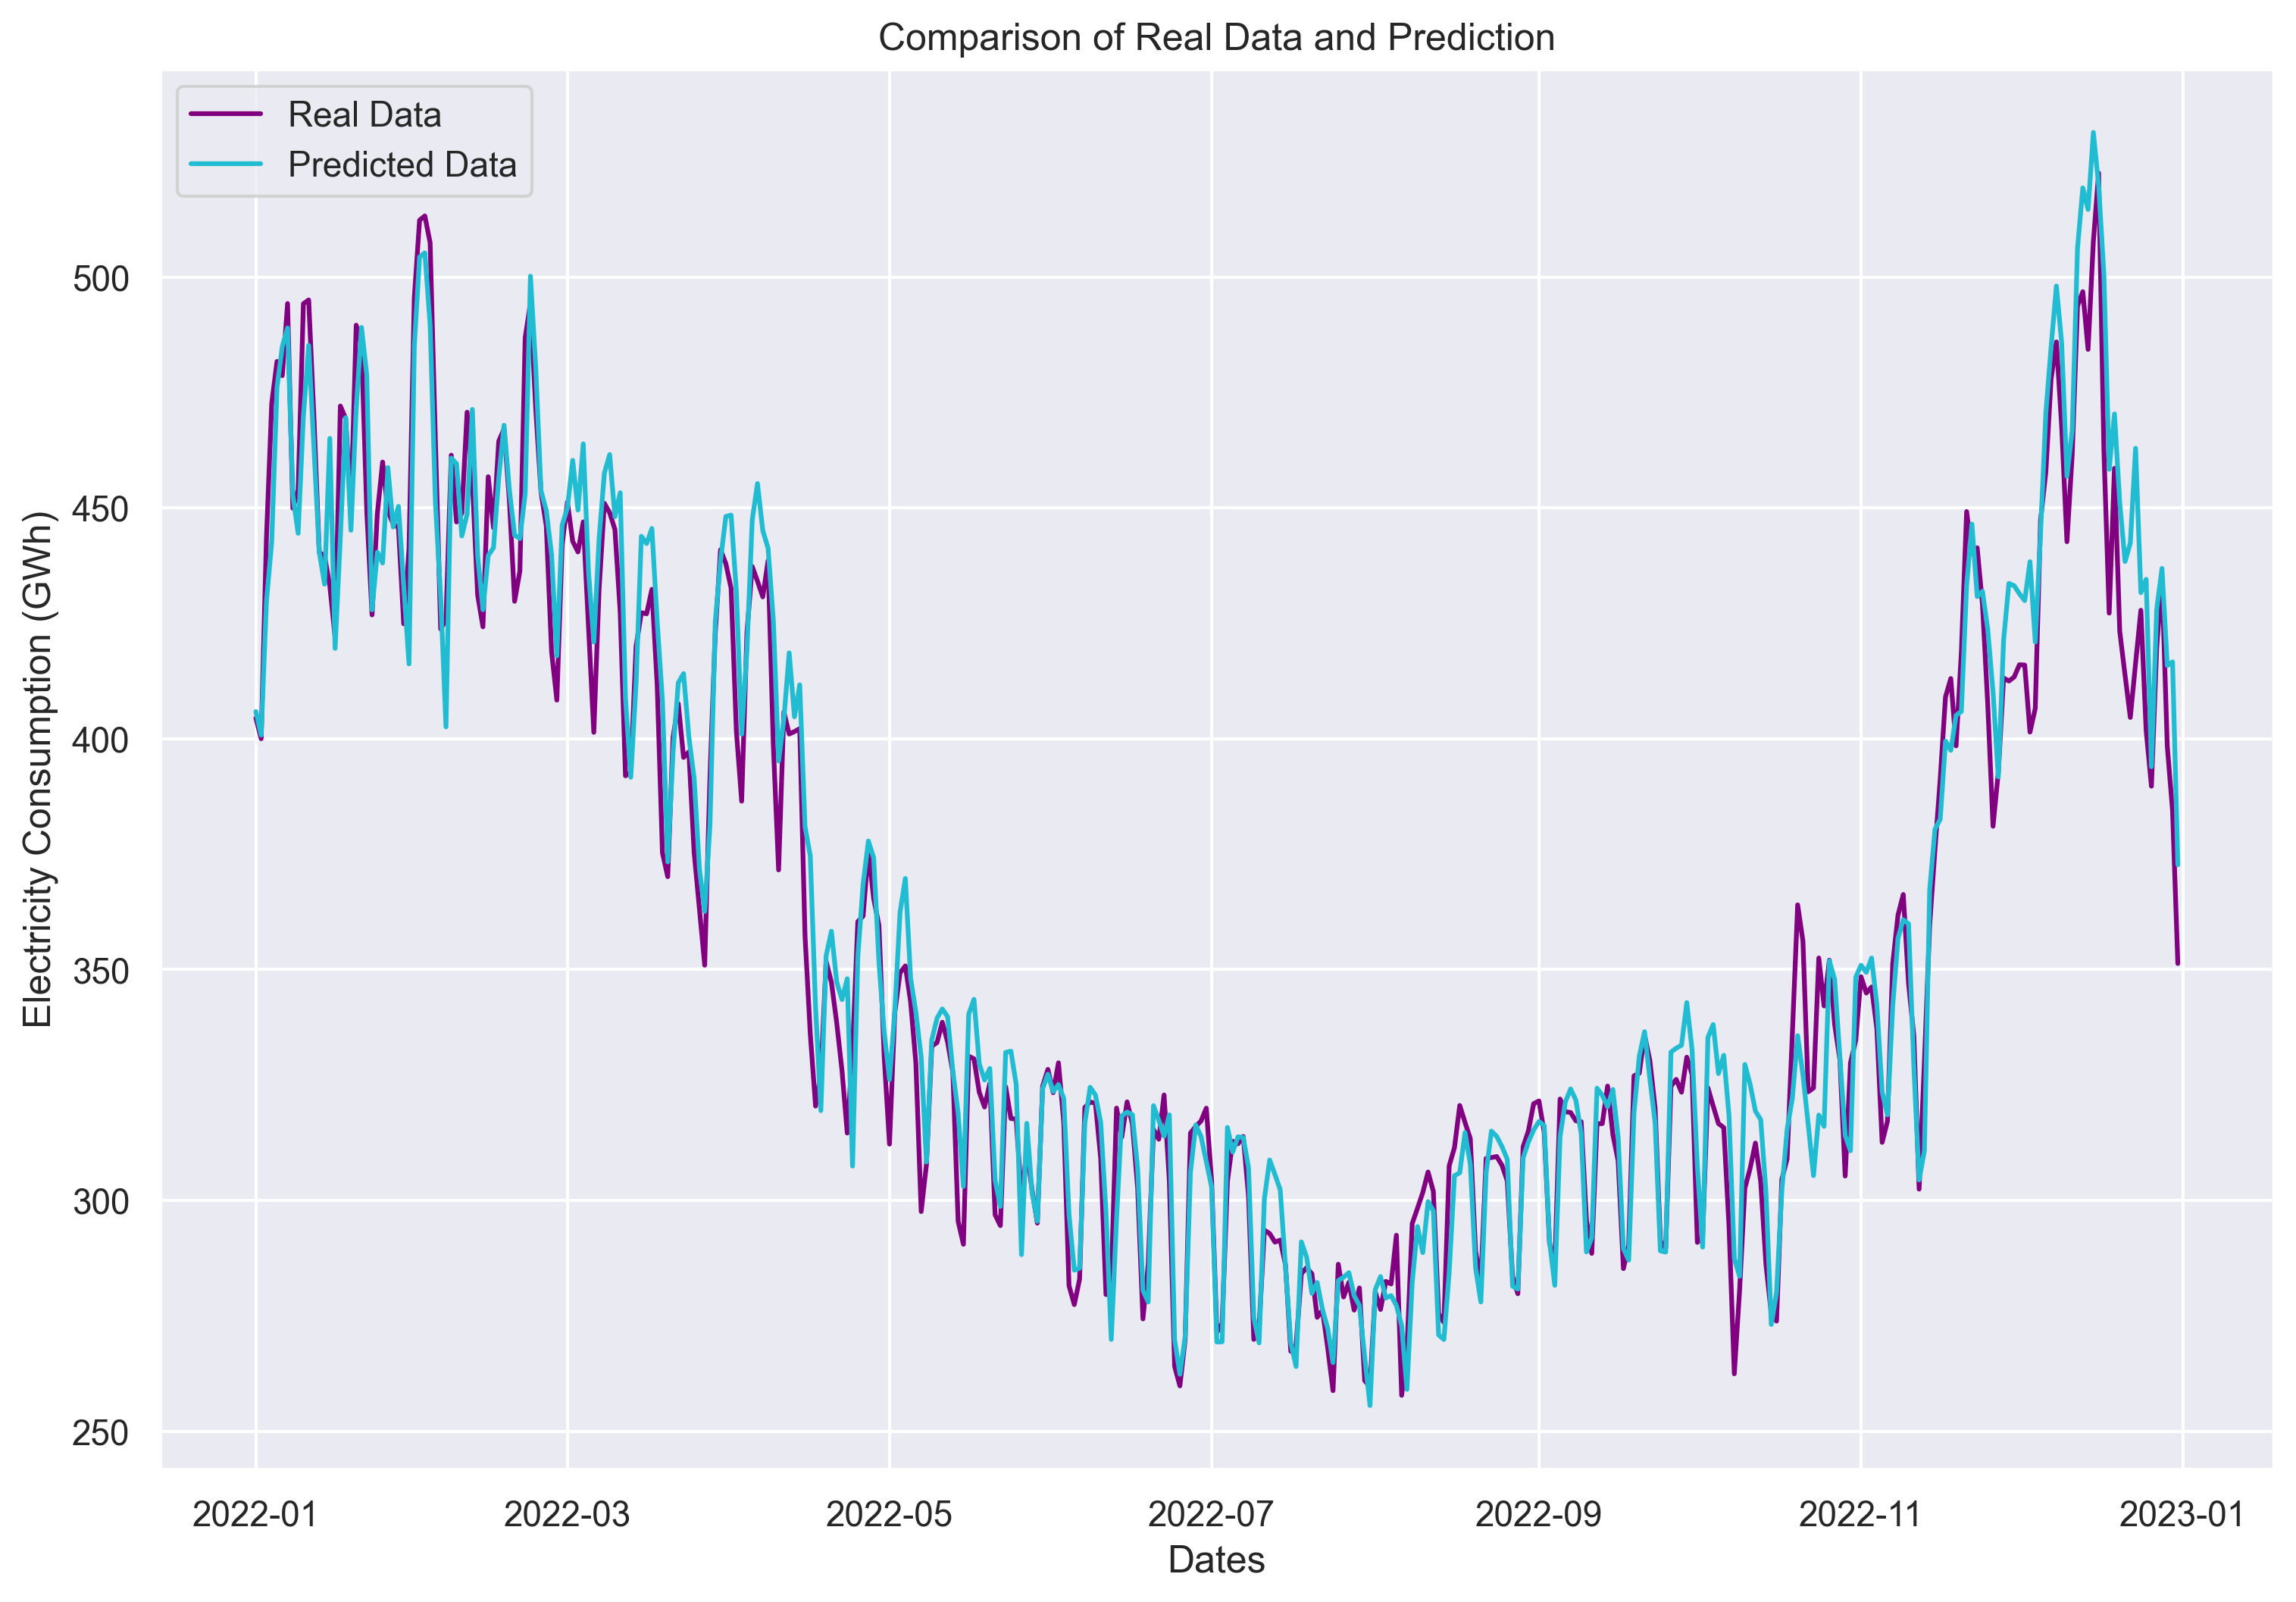

In [55]:
# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot y_test as a blue line
sns.lineplot(data=test_set, x='Date', y='y_test', label='Real Data', color='purple')

# Plot y_pred as a red line
sns.lineplot(data=test_set, x='Date', y='y_pred', label='Predicted Data', color='#21BCD1')

# Add labels and a legend
ax.set_xlabel('Dates')
ax.set_ylabel('Electricity Consumption (GWh)')
ax.set_title('Comparison of Real Data and Prediction')
ax.legend()

# Show the plot
plt.show()

## Conclusion

- `Achievement`: Developed an accurate forecasting model, using lagged values.
- `MAE Interpretation`: Predictions are off by 9.80 GWh (acceptable given large values).
- `Business Impact`: a reduced MAE translates to more precise budgeting for energy resources, resulting in potential cost savings.
- `Next Steps`: Implement model for 2022 daily forecasting with day-ahead assumption.